### Loading Modules

In [1]:
import time, os
from math import pi

from imageio import imwrite
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path as ppath
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

import Map_Functions as MF # function library included in this repo
import tol_colors as tc # colourblind-friendly colourmaps
irid = tc.iridescent

on = 1
off = 0

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# CGI Grid size (per 1 dimension) of the final landscape exported to Blender
BlenderGridSize = 512

In [3]:
MC = [129, 1920, 801, 1568] # marsh corner coordinates (x_min, x_max, y_min, y_max)
print(f"Block dimensions: {MC[1] - MC[0] + 1} x {MC[3] - MC[2] + 1}")

Block dimensions: 1792 x 768


### Loading the saltmarsh simulation

In [4]:
# Load model outputs
Data = np.load("inputs.npz")
print("Data keys: ", list(Data.keys()))

Elevation = Data['Elevation']
shape = Elevation.shape

Dyke_Poly = Data['Dyke_Poly']
Dyke_Profile = Data['Dyke_Profile']
Flat_mask = Data['Flat_mask']
Grid_Width = Data['Grid_Width']
Grid_Height = Data['Grid_Height']

Dyke_Poly = np.concatenate((Dyke_Poly, [(2048,2048), (0,2048)]))
Dyke_mask = Dyke_Profile>0.05
Polder_mask = MF.MakePolyMask(Dyke_Poly, shape)*(1-Dyke_mask)

Sediment = MF.MergeData(Data['Sediment'], shape, MC)
Shear = MF.MergeData(Data['Shear'], shape, MC)
Vegetation = MF.MergeData(Data['Vegetation'], shape, MC)

del Data

# Define vegetation cover
Vegetation = np.maximum(0, Vegetation - (Dyke_Profile > 0.1))

Boundaries = np.ones(shape)
Boundaries[:, 0] = 0
Boundaries[:, -1] = 0
Boundaries[0:MC[0], :] = 0

GrowthDamp = np.zeros(shape)
GrowthDamp[(MC[2]+100):(MC[3]+1), (MC[0]):(MC[1]+1)] = 1.0
GrowthDamp = gaussian_filter(GrowthDamp, sigma=50)
GrowthDamp = MF.DiffuseBoundaries(GrowthDamp, Boundaries, 0, 15)

GrowthDamp = np.minimum(GrowthDamp, (1 - Dyke_Profile))

Data keys:  ['Elevation', 'Dyke_Poly', 'Dyke_Profile', 'Flat_mask', 'Sediment', 'Vegetation', 'Shear', 'Grid_Width', 'Grid_Height']


### Plotting the whole lot

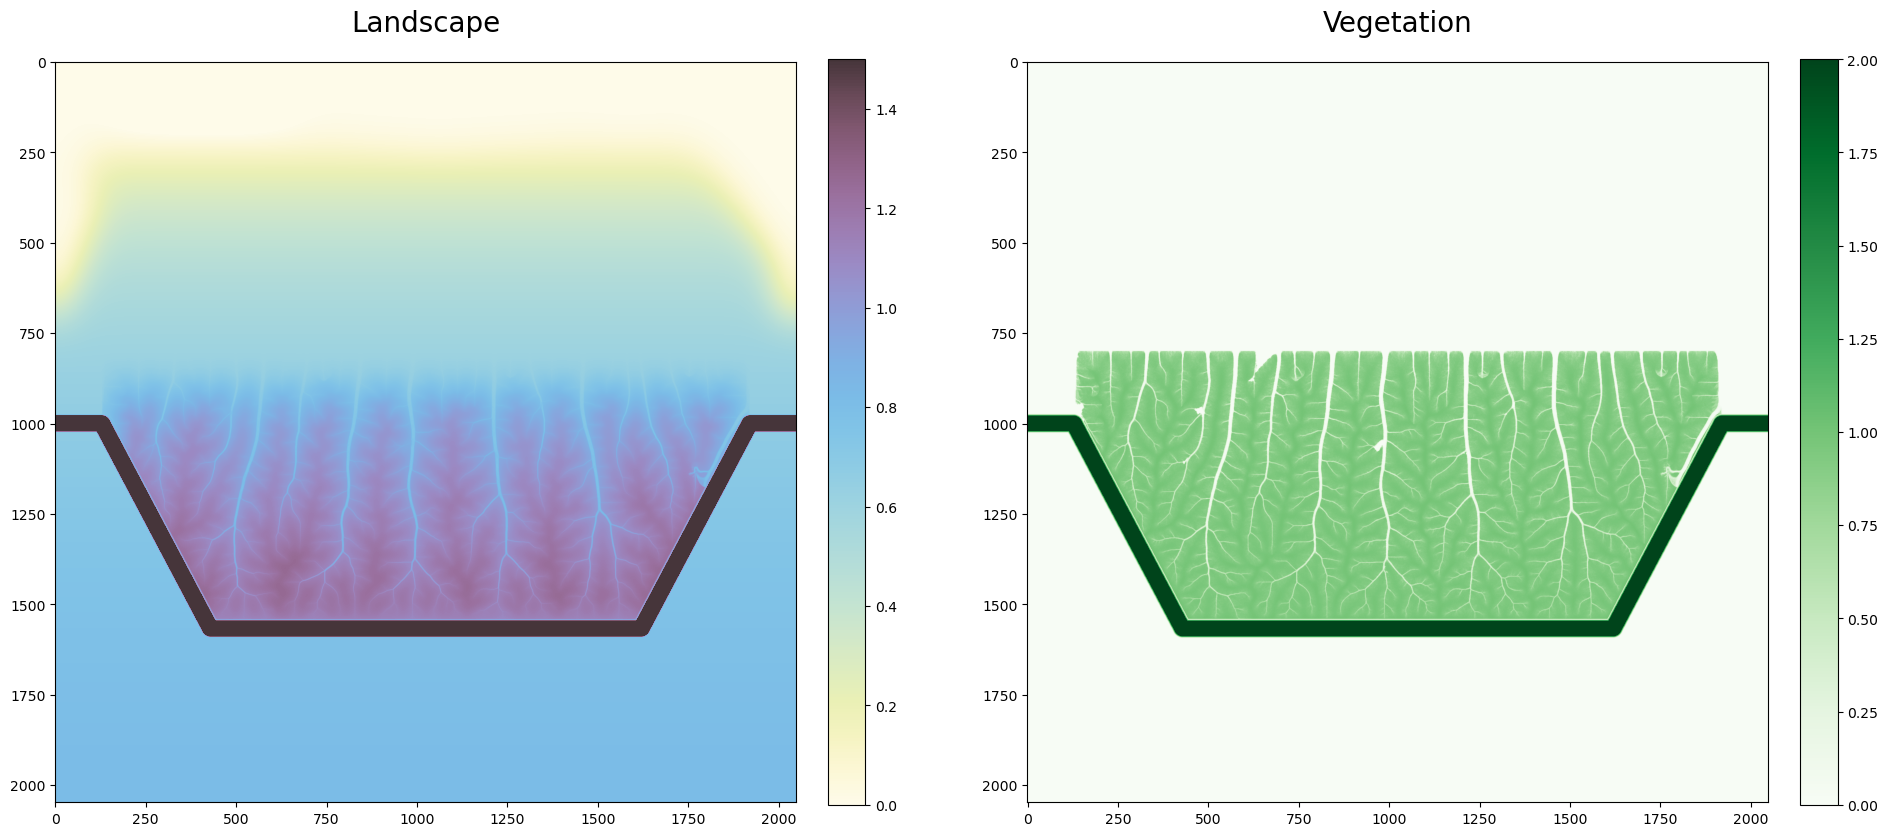

In [5]:
Landscape = np.maximum(Elevation + Sediment * GrowthDamp, Dyke_Profile)
Eb = np.maximum(Vegetation, Dyke_Profile)

fig, ax = plt.subplots(1, 2, figsize=(23, 20))
MF.PlotPanel(fig, ax[0], Landscape * (1 - Polder_mask), title="Landscape", cmap=irid, clim=(0, 1.5))
MF.PlotPanel(fig, ax[1], Eb, title="Vegetation", cmap="Greens", clim=(0, 2))

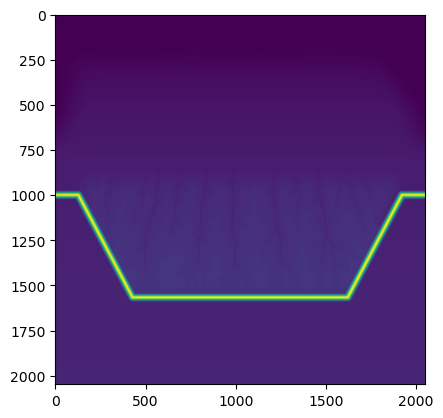

In [6]:
plt.imshow(Landscape)

## Making a creek map

In [7]:
ShearMap = Shear * GrowthDamp
ShearMap = np.minimum(1, ShearMap * 0.5)

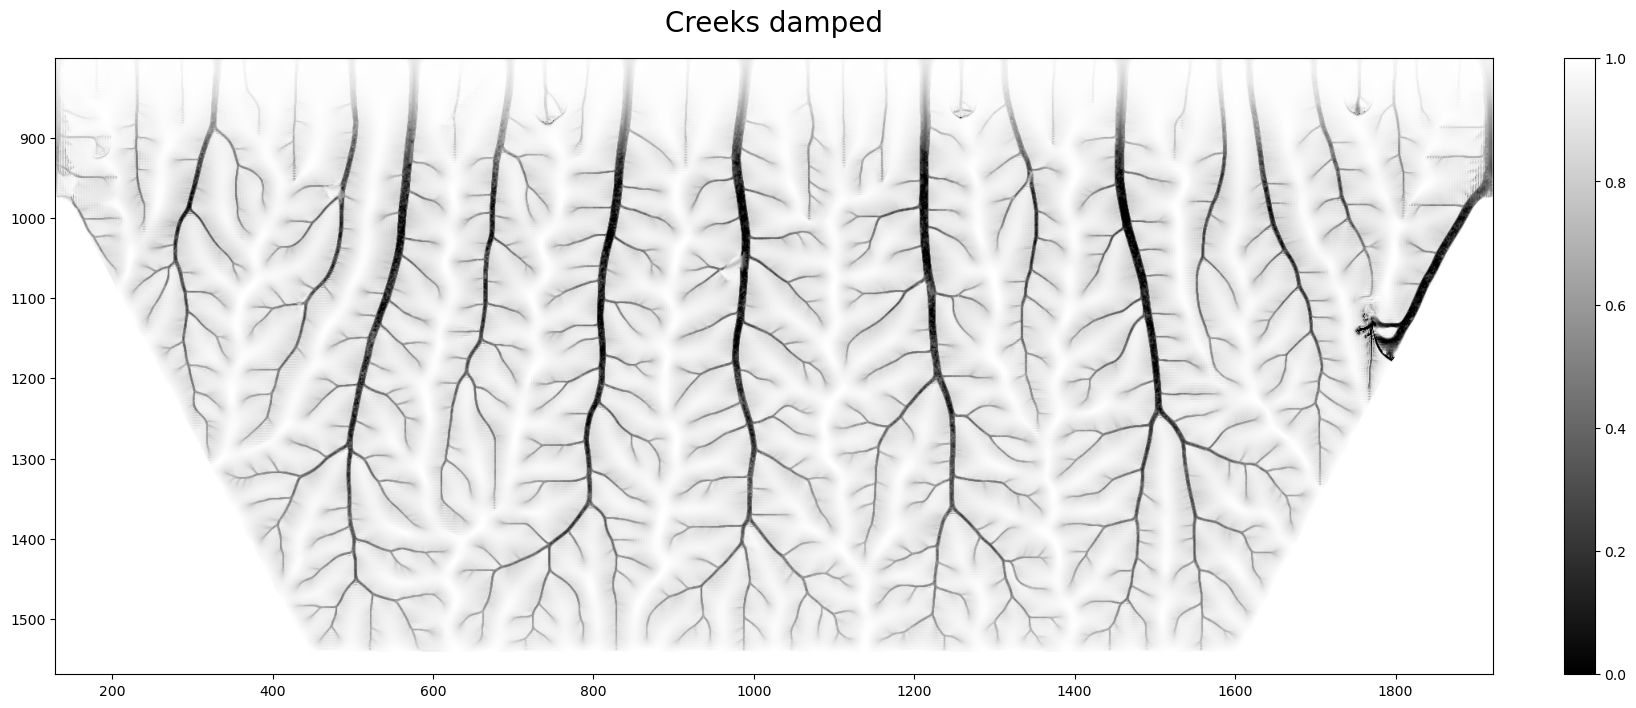

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(23, 8))

xylim = (0, 2047, 0, 2047)
xylim = (MC[0], (MC[1] + 1), MC[2], (MC[3] + 1))

MF.PlotPanel(fig, ax, 1 - ShearMap, title="Creeks damped", cmap="gray", xylim=xylim, clim=(0, 1))

### Loading the mussel simulation¶

In [9]:
Data = np.load("MusselData.npz")
print("Data keys: ", list(Data.keys()))

Data keys:  ['Mussels', 'Algae', 'Elevation', 'Length', 'Grid_Width', 'Grid_Height']


In [10]:
MB = Data["Elevation"]
Length = Data["Length"]
Grid_Width = Data["Grid_Width"]
Grid_Height = Data["Grid_Height"]

del Data

print(f"Grid size {Grid_Width} x {Grid_Height} cells, with Length {Length:.1f}.")

Grid size 512 x 512 cells, with Length 400.0.


### Placing the mussel bed

In [11]:
# Coordinates of the old grid on the new grid
ScaleMultiplyer = 4
NewScale = Grid_Width * ScaleMultiplyer

R = np.linspace(ScaleMultiplyer / 2 - 1, ScaleMultiplyer / 2 - 1 + (Grid_Width - 1) * ScaleMultiplyer, Grid_Width)
X, Y = np.meshgrid(R, R)

In [12]:
LandscapeLength = 2048

# Grid coordinates for the interpolation
Rn = np.linspace(0, ScaleMultiplyer * Grid_Width - 1, ScaleMultiplyer * Grid_Height)
Xn, Yn = np.meshgrid(Rn, Rn)

Location = (-200, -400)
Dimension = (192, 192)
Rotation = -70
Scale = NewScale / LandscapeLength

Pos = (Scale * (LandscapeLength / 2 + Location[0]), Scale * (LandscapeLength / 2 + Location[1]))
Dim = (Dimension[0] * Scale, Dimension[1] * Scale)

Rx = np.linspace(Pos[0] - Dim[0], Pos[0] + Dim[0], Grid_Width)
Ry = np.linspace(Pos[1] - Dim[1], Pos[1] + Dim[1], Grid_Height)
Xm, Ym = np.meshgrid(Rx, Ry)

Xr, Yr = MF.Rotate(Rotation, Pos, Xm, Ym)

Musselbed = np.rot90(MB / np.max(MB), k=2)

start_time = time.time()
MusselGrid = griddata((Xr.flatten(), Yr.flatten()), Musselbed.flatten(), (Xn.flatten(), Yn.flatten()), method="cubic", fill_value=0)
print(f"This took {(time.time() - start_time):.1f} seconds.")

This took 14.3 seconds.


### Diffusing the mussel bed to create the mussel habitat

In [13]:
Mussels = MusselGrid.reshape(NewScale, NewScale)
MusselsD = gaussian_filter(Mussels, sigma=25)
MusselsD = np.maximum(MusselsD / np.max(MusselsD) * 5.0, 0)

### Designating habitat types that drive the landschape texture

In [14]:
MusselHabitat = np.minimum(MusselsD, 1)
MarshHabitat = GrowthDamp * Flat_mask
MegarippleHabitat = MF.Normalise(MF.Cover(Elevation, 10, 0.3) * MF.Cover(Yn, -0.05, 500)) - MusselHabitat
WaterEdgeHabitat = MF.Normalise(
    MF.Cover(Elevation, 10, 0.7) * MF.Cover(Elevation, -20, 0.5)
) - MegarippleHabitat - MusselHabitat

DykeRevetment = (Dyke_Profile > 0.05) * (Dyke_Profile < 4) * (1 - MF.MakePolyMask(Dyke_Poly, shape))
DykeHabitat = (Dyke_Profile > 0.05) - DykeRevetment

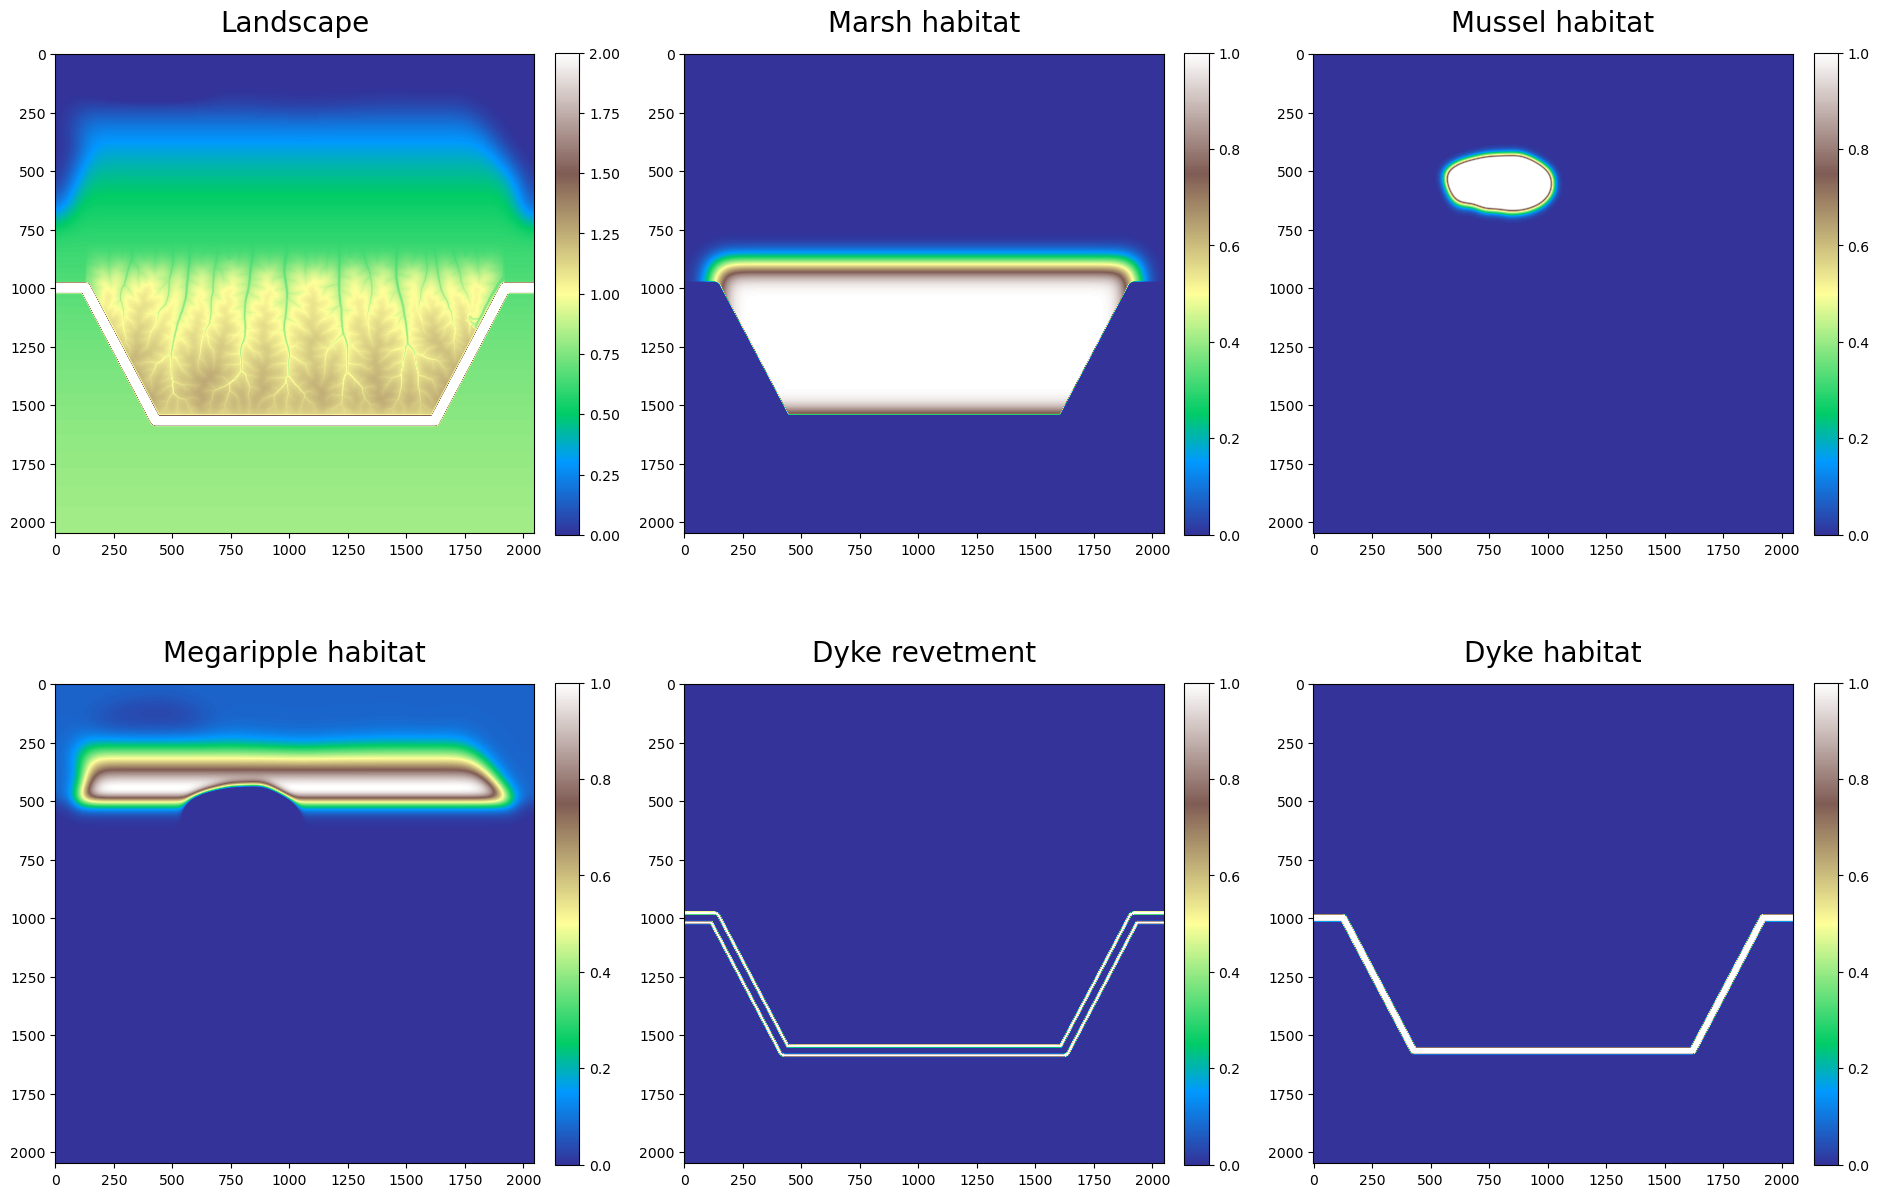

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(23, 15))
MF.PlotPanel(fig, ax[0][0], Landscape, title="Landscape", clim=(0,2))
MF.PlotPanel(fig, ax[0][1], MarshHabitat, title="Marsh habitat")
MF.PlotPanel(fig, ax[0][2], MusselHabitat, title="Mussel habitat")

MF.PlotPanel(fig, ax[1][0], MegarippleHabitat, title="Megaripple habitat")
MF.PlotPanel(fig, ax[1][1], DykeRevetment, title="Dyke revetment")
MF.PlotPanel(fig, ax[1][2], DykeHabitat, title="Dyke habitat")

## The vegetation - Phragmites, Scirpus, Aster

### Adding some noise
We use pre-prepared arrays of random noise at different resolutions to improve the natural feel of the visualisations.

In [16]:
Data = np.load("RandomFields.npz")
print("Data keys: ", list(Data.keys()))

CoarseField = Data["CoarseField"]
FineField = Data["FineField"]
SuperFineField = Data["SuperFineField"]

del Data

Data keys:  ['CoarseField', 'FineField', 'SuperFineField']


### Setting up habitat maps for the different plant species

In [17]:
# Defining the scale of the landscape
Size = 2048

In [18]:
SD = 100        # Slope of the tall grass
ND = 0.5      # Threshold of the tall grass
VD = MF.Cover(SuperFineField, SD, ND)

Dyke_TallGrass = (0.1 * DykeRevetment + DykeHabitat) * (0.5 + 0.5 * VD)
Dyke_GreyGrass = (0.1 * DykeRevetment + DykeHabitat) * (1 - VD)

Dyke_Cover = ((Dyke_Profile>0.15) * (Dyke_Profile<2) ) * 1.0

Marsh_Elymus = (Vegetation > 0.96) * 1.0
Marsh_High = np.maximum(0, Vegetation * MF.Cover(Sediment, 100, 0.35) - Marsh_Elymus)
Marsh_Low = np.maximum(0, Vegetation * MF.Cover(Sediment, 100, 0.30) - Marsh_High - Marsh_Elymus)
Marsh_Pioneer = np.maximum(0, Vegetation - Marsh_Low - Marsh_High - Marsh_Elymus - Shear)

Marsh_Limonium = Marsh_High * VD
Marsh_Artemisia = Marsh_High * (1 - VD)

Marsh_Atriplex = Marsh_Low * VD
Marsh_Juncus = Marsh_Low * (1 - VD)

Marsh_Salicornia = Marsh_Pioneer * VD
Marsh_Suaeda = Marsh_Pioneer * (1 - VD)

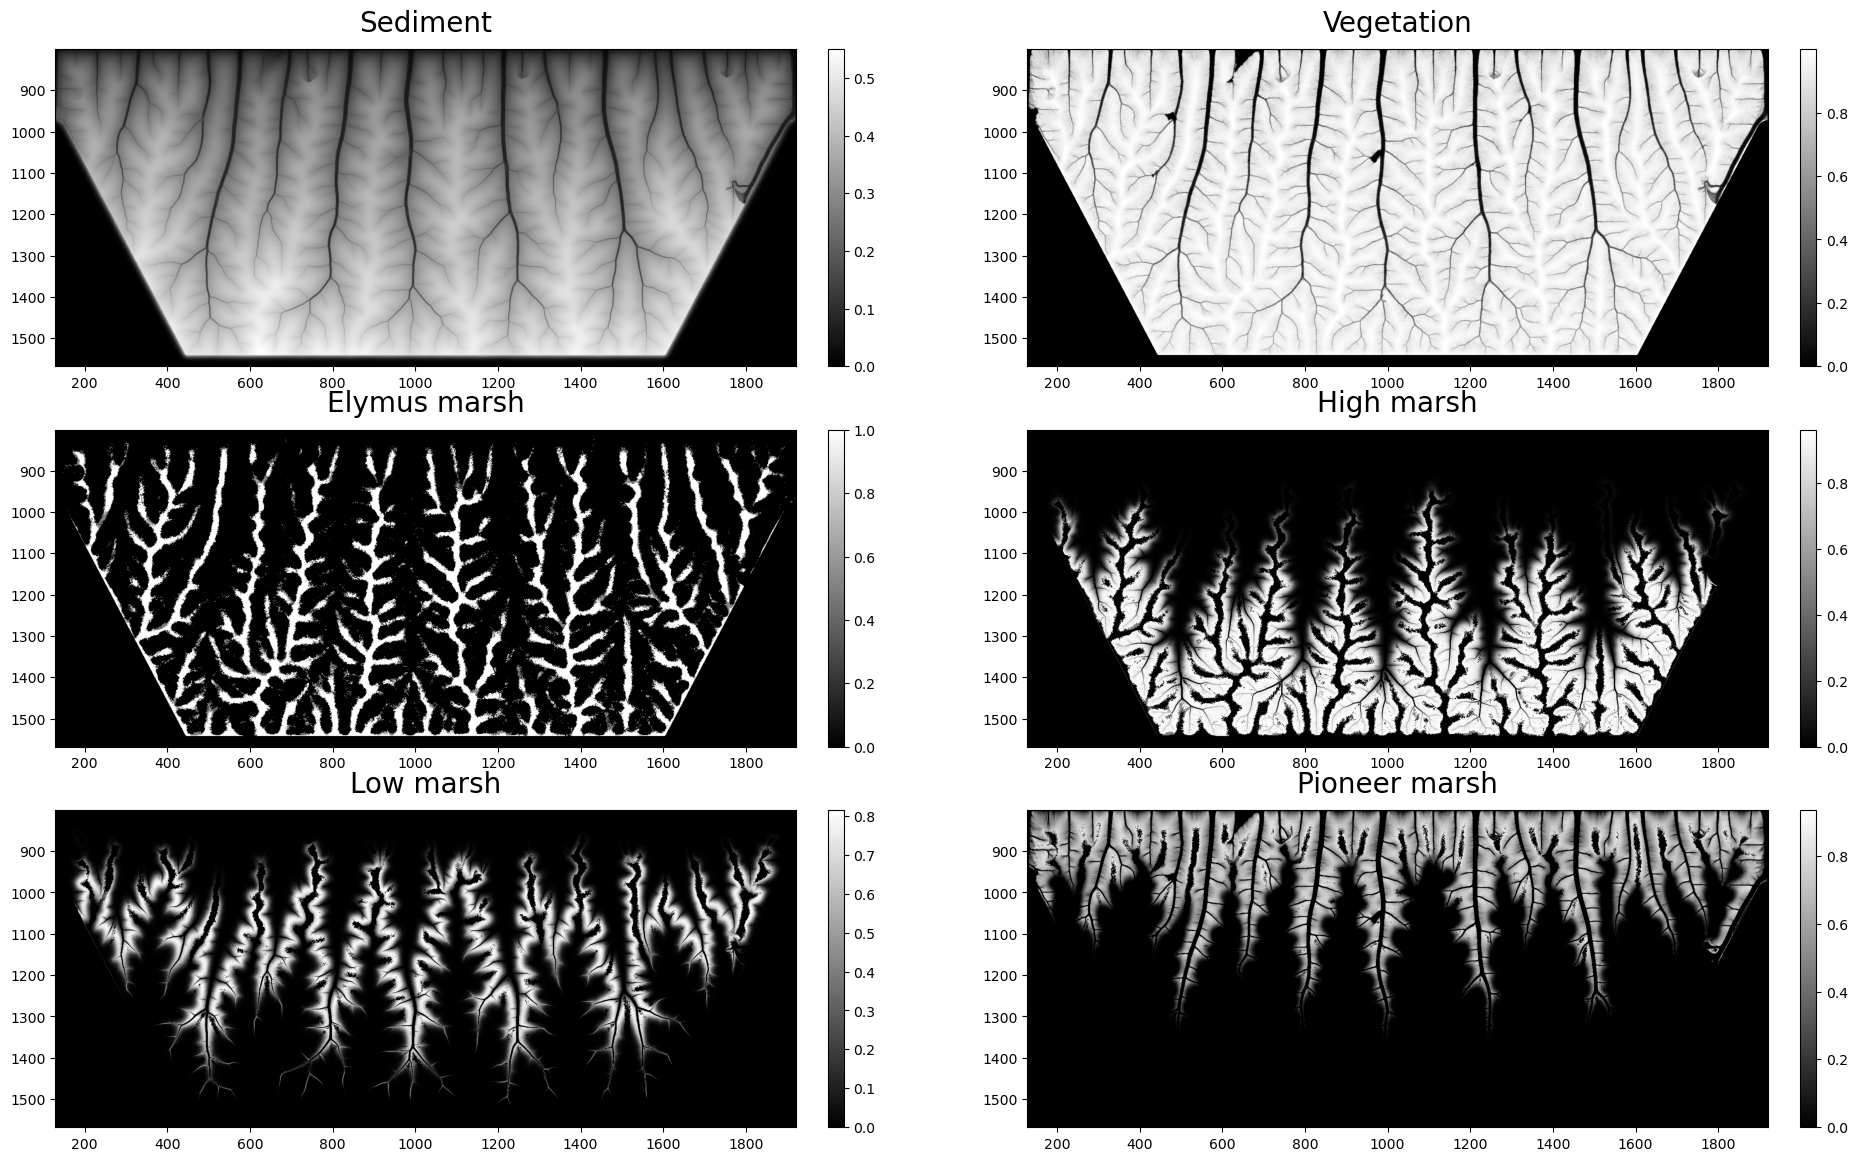

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(23, 14))

xylim = (MC[0], MC[1], MC[2], MC[3])
MF.PlotPanel(fig, ax[0][0], Sediment, title="Sediment", cmap="gray", xylim=xylim, colorbar=True)
MF.PlotPanel(fig, ax[0][1], Vegetation, title="Vegetation", cmap="gray", xylim=xylim, colorbar=True)
MF.PlotPanel(fig, ax[1][0], Marsh_Elymus, title="Elymus marsh", cmap="gray", xylim=xylim, colorbar=True)
MF.PlotPanel(fig, ax[1][1], Marsh_High, title="High marsh", cmap="gray", xylim=xylim, colorbar=True)
MF.PlotPanel(fig, ax[2][0], Marsh_Low, title="Low marsh", cmap="gray", xylim=xylim, colorbar=True)
MF.PlotPanel(fig, ax[2][1], Marsh_Pioneer, title="Pioneer marsh", cmap="gray", xylim=xylim, colorbar=True);

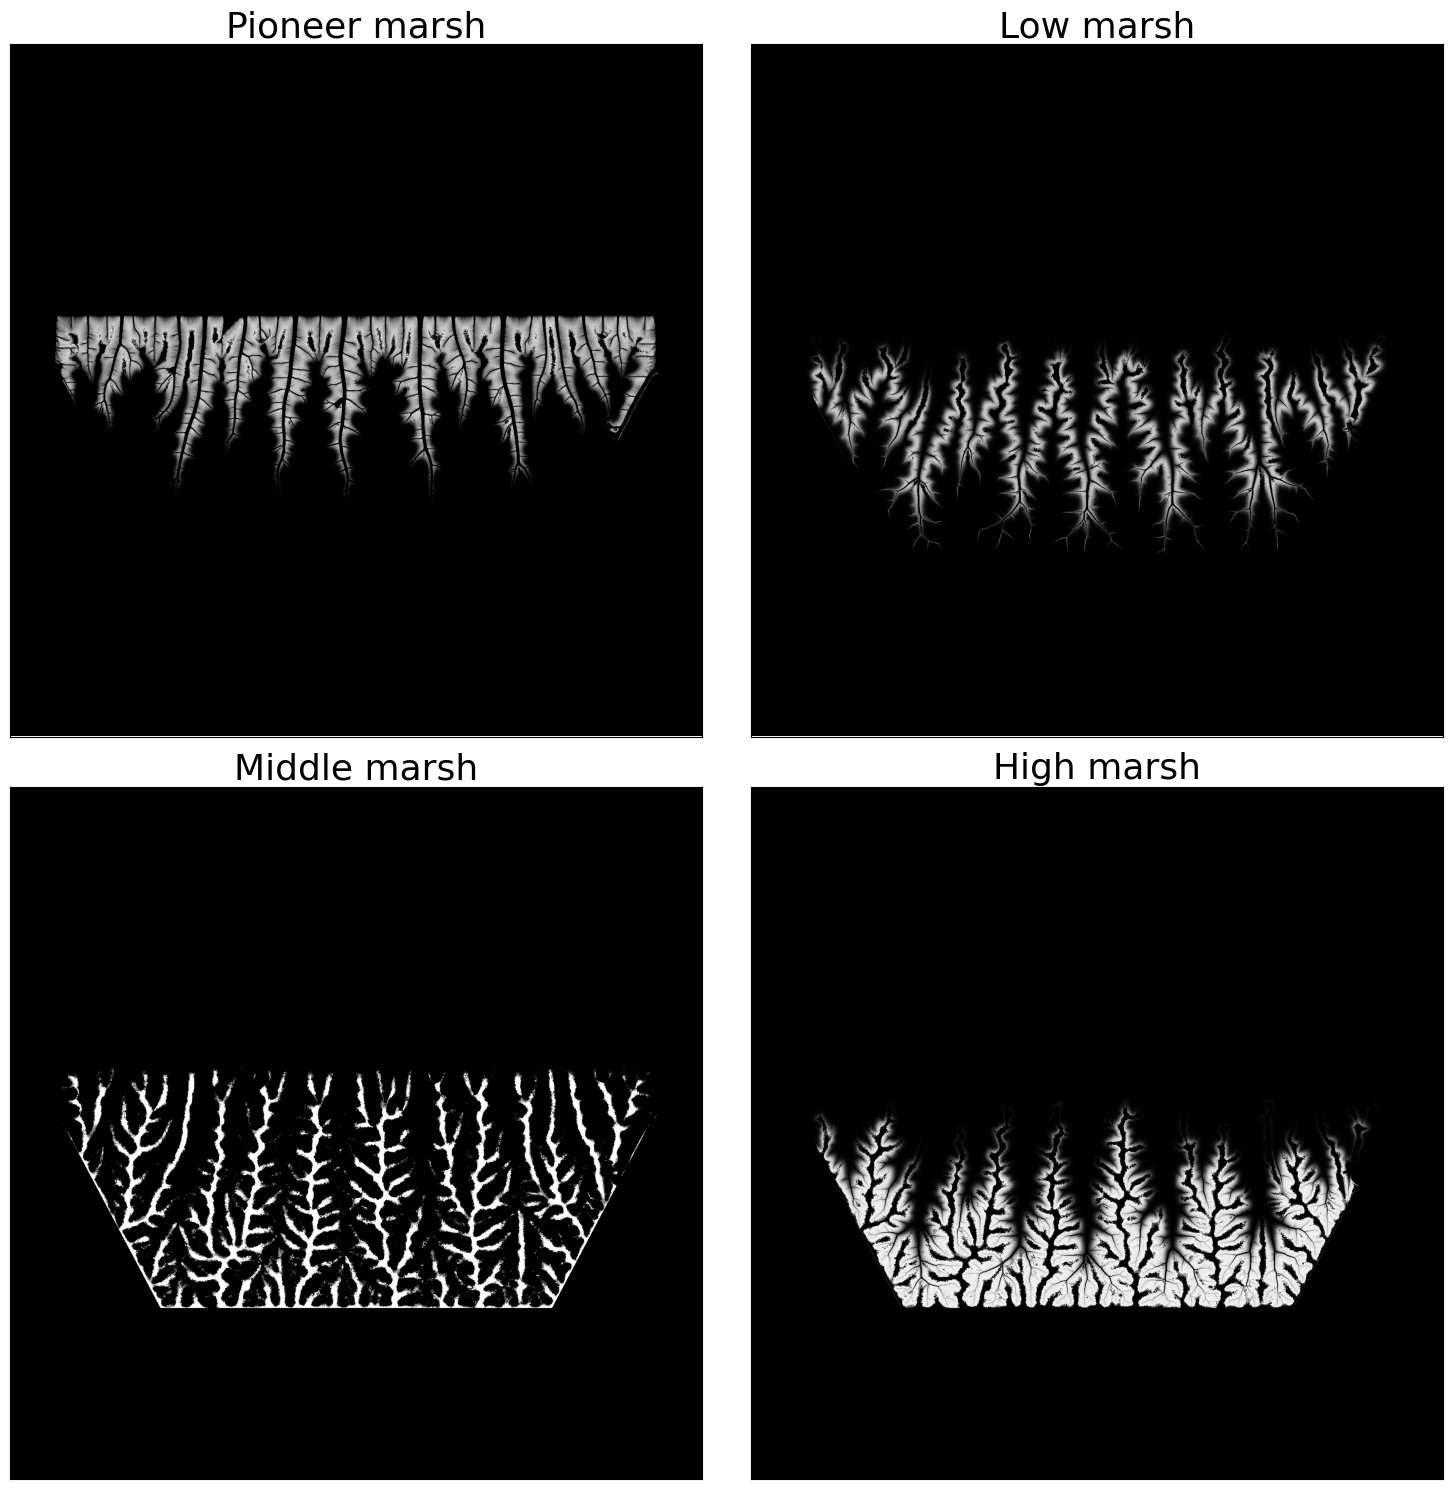

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

xylim = (0, Size, 0, Size)
ax[0,0].imshow(Marsh_Pioneer, cmap="gray", clim=(0,1))
ax[0,0].set_title("Pioneer marsh", fontsize=26)
ax[0,1].imshow(Marsh_Low, cmap="gray", clim=(0,1))
ax[0,1].set_title("Low marsh", fontsize=26)
ax[1,0].imshow(Marsh_Elymus, cmap="gray", clim=(0,1))
ax[1,0].set_title("Middle marsh", fontsize=26)
ax[1,1].imshow(Marsh_High, cmap="gray", clim=(0,1))
ax[1,1].set_title("High marsh", fontsize=26)

for axis in ax.flatten():
    axis.set_xlim((xylim[0], xylim[1]))
    axis.set_ylim((xylim[3], xylim[2]))
    axis.set_xticks([])
    axis.set_yticks([])

plt.tight_layout();

### Shells, by J. van de Koppel Jr.

In [21]:
Shells = FineField * (1 - MarshHabitat) * (1 + Mussels)
Shells = Shells / np.max(Shells)

### Coords and Loops data, needed to construct the landscape in Blender

In [22]:
LandscapeSize = 2048

R = np.linspace(-LandscapeSize / 2, LandscapeSize / 2, BlenderGridSize)

X, Y = np.meshgrid(R, R)

Coords = np.zeros((BlenderGridSize ** 2, 2))
Coords[:, 0] = X.flatten()
Coords[:, 1] = Y.flatten()

LoopNr = (BlenderGridSize - 1) * (BlenderGridSize - 1)

VertexNr = np.linspace(0, BlenderGridSize ** 2 - 1, BlenderGridSize ** 2).reshape(BlenderGridSize, BlenderGridSize)
Loops = np.zeros((LoopNr, 4), dtype=np.int32)
LoopStart = np.zeros((LoopNr, 1))

i = 0
for x in range(BlenderGridSize - 1):
    for y in range(BlenderGridSize - 1):
        Loops[i,:] = (VertexNr[x, y], VertexNr[x, y+1], VertexNr[x+1, y+1], VertexNr[x+1, y])
        i = i + 1

### Defining the material file that defines the landscape

In [23]:
Landscape_Material = "Estuary_Realigned_Materials.blend"
HabitatMaps = [
    {"Tex": "SaltmarshLocation",     "Map": "Flat_MarshHabitat.png"}, 
    {"Tex": "MegarippleLocation",    "Map": "Flat_DykeRevetment.png"},
    {"Tex": "DykeRevetmentLocation", "Map": "Flat_DykeRevetment.png"},
    {"Tex": "DykeLocation",          "Map": "Flat_DykeHabitat.png"}
]

### Defining the vegetation libraries

In [24]:
Libraries=[
{"filename": "Particles/Trees/Trees.blend",                   "Collection": "Trees"},
{"filename": "Particles/RuderalPlants/RuderalPlants.blend",   "Collection": "RuderalPlants"},
{"filename": "Particles/Saltmarsh/Saltmarsh_plants.blend",    "Collection": "Saltmarsh"},
{"filename": "Particles/Tidalflat/Tidalflat_organisms.blend", "Collection": "Tidalflat"}, 
{"filename": "Particles/Animals/Animals.blend",               "Collection": "Animals"},
{"filename": "Particles/Brackishmarsh/Brackishmarsh.blend",   "Collection": "Brackishmarsh"}
]

### Setting up the vegetation database

In [25]:
shape = (BlenderGridSize, BlenderGridSize)

In [26]:
VegetationDatabase = [
     {"Name":          "Dyke_TallGrass", 
      "Density":       25,
      "Vertex":        MF.Conv(Dyke_TallGrass, shape),
      "DampVertex":    False,
      "Collection":    "TallTufts",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       ""},

     {"Name":          "Dyke_GreyGrass",
      "Density":       25,
      "Vertex":        MF.Conv(Dyke_GreyGrass, shape),
      "DampVertex":    False,
      "Collection":    "GreyTufts",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       ""},    

     {"Name":          "Elymus",
      "Density":       25,
      "Vertex":        MF.Conv(Marsh_Elymus, shape),
      "DampVertex":    True,
      "Collection":    "Elytrigia",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_VegetationMap.png"},

     {"Name":          "Marsh_Limonium",
      "Density":       50,
      "Vertex":        MF.Conv(Marsh_Limonium, shape),              
      "DampVertex":    True,
      "Collection":    "Limonium",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_FineVegPatches.png"},

     {"Name":          "Marsh_Artemisia",
      "Density":       30,
      "Vertex":        MF.Conv(Marsh_Artemisia, shape),              
      "DampVertex":    True,
      "Collection":    "Artemisia",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_VegetationMap.png"},

     {"Name":          "Marsh_Juncus",
      "Density":       50,
      "Vertex":        MF.Conv(Marsh_Juncus, shape),  
      "DampVertex":    True,
      "Collection":    "Juncus",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_VegetationMap.png"},

     {"Name":          "Marsh_Atriplex",
      "Density":       50,
      "Vertex":        MF.Conv(Marsh_Atriplex, shape),                
      "DampVertex":    True,
      "Collection":    "Atriplex",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_VegetationMap.png"},

     {"Name":          "Marsh_Salicornia",
      "Density":       20,
      "Vertex":        MF.Conv(Marsh_Salicornia, shape),                
      "DampVertex":    True,
      "Collection":    "Salicornia",
      "Kids":          50,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_FineVegPatches.png"},

     {"Name":          "Marsh_Suaeda",
      "Density":       10,
      "Vertex":        MF.Conv(Marsh_Suaeda, shape),                
      "DampVertex":    True,
      "Collection":    "Suaeda",
      "Kids":          100,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       "Flat_FineVegPatches.png"},  

     {"Name":          "Shells",
      "Density":       2,
      "Vertex":        MF.Conv(Shells, shape),                
      "DampVertex":    True,
      "Collection":    "Shells",
      "Kids":          10,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       ""},

     {"Name":          "Algae-Tidalflat",
      "Density":       0.1,
      "Vertex":        1,
      "DampVertex":    True,
      "Collection":    "Algae",
      "Kids":          25,
      "Rotation_mode": "NOR_TAN",
      "TexFile":       ""},    
]     

### Place cameras
These will determine the user's point of view in the final visualisation.

In [27]:
Cameras = [
    {"Name": "Camera 01", "Loc": (250, 400, 50),    "Rot": (90 / 180 * pi, 0, -45 / 180 * pi)},
    {"Name": "Camera 02", "Loc": (1750, 1700, 100), "Rot": (90 / 180 * pi, 0, -210 / 180 * pi)},
]

Visualy verify location and orientation of cameras:

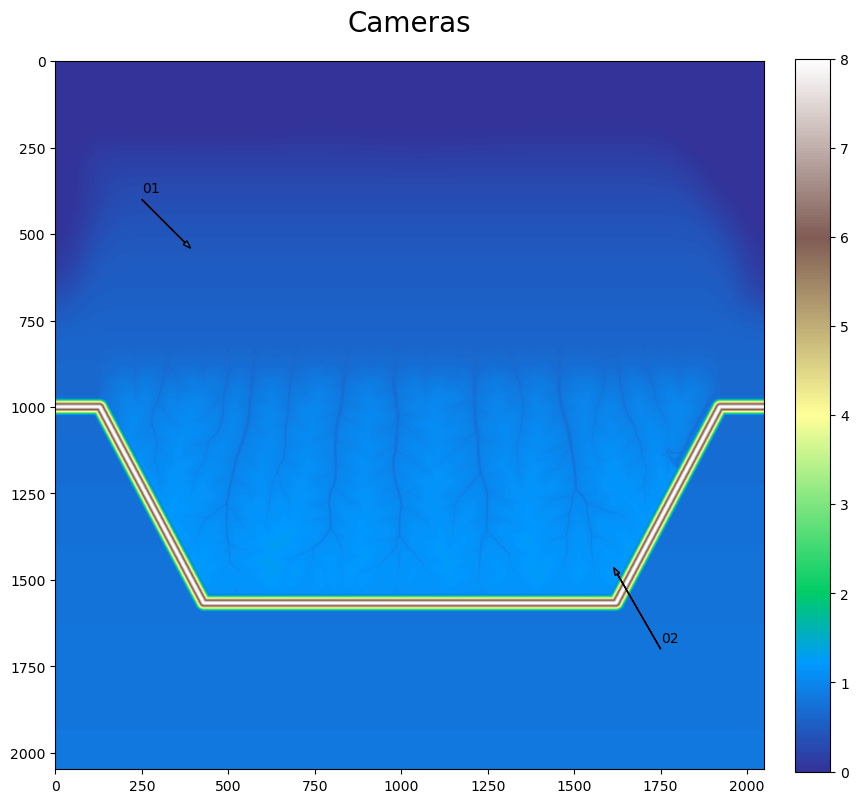

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
MF.PlotPanel(fig, ax, Landscape, title="Cameras", cmap="terrain")
for Cam in Cameras:
    ax.arrow(Cam["Loc"][0], Cam["Loc"][1], -25 * np.sqrt(Cam["Loc"][2]) * np.sin(Cam["Rot"][2]),
             25 * np.sqrt(Cam["Loc"][2]) * np.cos(Cam["Rot"][2]), head_width=15)
    ax.text(Cam["Loc"][0], Cam["Loc"][1] -20, Cam["Name"][7:])

### Saving the data

In [29]:
Save = on

if Save == on:
    
    Folder = "FlatMaps"
    ppath(Folder).mkdir(parents=True, exist_ok=True)
    np.savez(os.path.join(Folder, "FlatMap.npz"),
             
             Coords            = Coords,
             Loops             = Loops,
             ElevationRaw      = Elevation,
             Elevation         = MF.Conv(Landscape, shape),
             Saltmarsh         = MF.Conv(Sediment, shape),
             Vegetation        = MF.Conv(Vegetation, shape),
             Mussels           = MF.Conv(Mussels, shape),
             Dyke_TallGrass    = MF.Conv(Dyke_TallGrass, shape),
             Dyke_GreyGrass    = MF.Conv(Dyke_GreyGrass, shape),
             DykeCover         = MF.Conv(Dyke_Cover, shape),
             Marsh_Elymus      = MF.Conv(Marsh_Elymus, shape),
             Marsh_High        = MF.Conv(Marsh_High, shape),
             Marsh_Low         = MF.Conv(Marsh_Low, shape),
             Marsh_Pioneer     = MF.Conv(Marsh_Pioneer, shape),
             Marsh_Limonium    = MF.Conv(Marsh_Limonium, shape),
             Marsh_Artemisia   = MF.Conv(Marsh_Artemisia, shape),
             Marsh_Juncus      = MF.Conv(Marsh_Juncus, shape),
             Marsh_Atriplex    = MF.Conv(Marsh_Atriplex, shape),
             Marsh_Salicornia  = MF.Conv(Marsh_Salicornia, shape),
             Marsh_Suaeda      = MF.Conv(Marsh_Suaeda, shape),
             Shells            = MF.Conv(Shells, shape),
             
             Landscape         = np.flipud(MF.rebin(Landscape, (BlenderGridSize, BlenderGridSize))), 
             Landscape_Max     = np.max(Landscape),
             Landscape_Min     = np.min(Landscape),
             LandscapeSize     = LandscapeSize,
             Grid_Size         = Size,
             Blender_Grid_Size = BlenderGridSize,
             
             Landscape_Material = Landscape_Material,
             HabitatMaps        = HabitatMaps, 
             Libraries          = Libraries,
             VegetationDatabase = VegetationDatabase,
             Props              = {},
             Cameras            = Cameras            
             )

    np.savez(os.path.join(Folder, "FlatWorldImage.npz"), Elevation=MF.Conv(Landscape, shape))
    
    imwrite(os.path.join(Folder, "Flat_LandscapeMap.png"), (MF.Normalise(Landscape) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_VegetationMap.png"), (np.rot90(Vegetation > 0.7) * 255 ).astype("uint8"))
    imwrite(
            os.path.join(Folder, "Flat_Saltmarsh.png"),
                        MF.rebin(np.minimum(255, np.rot90(1 - ShearMap / np.max(ShearMap)) * 255), (1024,1024)).astype("uint8")
    )
    imwrite(os.path.join(Folder, "Flat_Mussels.png"), (np.rot90(Mussels / np.max(Mussels)) * 255 ).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_MusselsDamp.png"), (np.rot90(Mussels > 0.1) * 255).astype("uint8"))

    imwrite(os.path.join(Folder, "Flat_MarshHabitat.png"), (MF.MapHabitat(MarshHabitat) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_MusselHabitat.png"), (MF.MapHabitat(MusselHabitat) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_WaterEdgeHabitat.png"), (MF.MapHabitat(WaterEdgeHabitat) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_MegarippleHabitat.png"), (MF.MapHabitat(MegarippleHabitat) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_DykeHabitat.png"), (MF.MapHabitat(DykeHabitat) * 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_DykeRevetment.png"), (MF.MapHabitat(DykeRevetment) * 255).astype("uint8"))

    imwrite(os.path.join(Folder, "Flat_White.png"), (MarshHabitat * 0 + 255).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_Black.png"), (MarshHabitat * 0).astype("uint8"))
    imwrite(os.path.join(Folder, "Flat_FineVegPatches.png"), (MF.MapHabitat(VD * Vegetation) * 255).astype("uint8"))